<a href="https://colab.research.google.com/github/lluluciano0505/AI_Mobility/blob/main/2models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import duckdb
import pandas as pd

con = duckdb.connect("/content/drive/MyDrive/MOBILITY/mobility.duckdb")

con.execute("SHOW TABLES;").fetchdf()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,name
0,cell_poi_wide
1,flow
2,flow_poi


In [ ]:
info = con.execute("PRAGMA table_info('flow_poi');").fetchall()
all_cols = [r[1] for r in info]
poi_cols = [c for c in all_cols if c.startswith("poi_")]

print("lens of POI", len(poi_cols))
print("5 poi:", poi_cols[:5])


lens of POI 85
5 poi: ['poi_1', 'poi_2', 'poi_3', 'poi_4', 'poi_5']


In [ ]:
feature_cols = ["flow"] + poi_cols + ["tod_sin", "tod_cos", "dow_sin", "dow_cos"]

con.execute(f"""
    CREATE OR REPLACE TABLE flow_feat AS
    WITH base AS (
        SELECT
            d::INT AS d,
            t::INT AS t,
            x::INT AS x,
            y::INT AS y,
            flow,
            {", ".join([f"COALESCE({c}, 0) AS {c}" for c in poi_cols])},
            t AS time_of_day,
            d % 7 AS dow,
            (d * 48 + t) AS time_index
        FROM flow_poi
    ),
    feat AS (
        SELECT
            *,
            sin(2*PI()*time_of_day/48.0) AS tod_sin,
            cos(2*PI()*time_of_day/48.0) AS tod_cos,
            sin(2*PI()*dow/7.0)          AS dow_sin,
            cos(2*PI()*dow/7.0)          AS dow_cos,
            LEAD(flow) OVER (
                PARTITION BY x, y
                ORDER BY d, t
            ) AS flow_next
        FROM base
    )
    SELECT
        x,
        y,
        {", ".join(feature_cols)},
        flow_next,
        time_index
    FROM feat
    WHERE flow_next IS NOT NULL;
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
print(con.execute("SELECT COUNT(*) FROM flow_feat;").fetchall())
print(con.execute("PRAGMA table_info('flow_feat');").fetchall()[:15])


[(39047304,)]
[(0, 'x', 'INTEGER', False, None, False), (1, 'y', 'INTEGER', False, None, False), (2, 'flow', 'BIGINT', False, None, False), (3, 'poi_1', 'BIGINT', False, None, False), (4, 'poi_2', 'BIGINT', False, None, False), (5, 'poi_3', 'BIGINT', False, None, False), (6, 'poi_4', 'BIGINT', False, None, False), (7, 'poi_5', 'BIGINT', False, None, False), (8, 'poi_6', 'BIGINT', False, None, False), (9, 'poi_7', 'BIGINT', False, None, False), (10, 'poi_8', 'BIGINT', False, None, False), (11, 'poi_9', 'BIGINT', False, None, False), (12, 'poi_10', 'BIGINT', False, None, False), (13, 'poi_11', 'BIGINT', False, None, False), (14, 'poi_12', 'BIGINT', False, None, False)]


In [ ]:
# 80% threshold
import numpy as np


threshold = con.execute("""
    SELECT quantile(time_index, 0.8) FROM flow_feat;
""").fetchone()[0]

con.execute("""
    CREATE OR REPLACE TABLE flow_feat_train AS
    SELECT * FROM flow_feat
    WHERE time_index <= ?;
""", [threshold])

con.execute("""
    CREATE OR REPLACE TABLE flow_feat_test AS
    SELECT * FROM flow_feat
    WHERE time_index > ?;
""", [threshold])

# mean / std
mean_row = con.execute(f"""
    SELECT {", ".join([f"avg({c}) AS {c}" for c in feature_cols])}
    FROM flow_feat_train;
""").fetchnumpy()

std_row = con.execute(f"""
    SELECT {", ".join([f"stddev_samp({c}) AS {c}" for c in feature_cols])}
    FROM flow_feat_train;
""").fetchnumpy()

mean = np.array([mean_row[c][0] for c in feature_cols], dtype="float32")
std  = np.array([std_row[c][0]  for c in feature_cols], dtype="float32") + 1e-6


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Linear define


In [ ]:
import torch
from torch import nn

input_dim = len(feature_cols)
hidden_dim = 64
num_layers = 2

class FlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [B, L, F]
        out, _ = self.lstm(x)          # out: [B, L, H]
        last_hidden = out[:, -1, :]    # [B, H] -> last time step
        y_pred = self.fc(last_hidden)  # [B, 1]
        return y_pred.squeeze(-1)      # [B]


class LinearSeqModel(nn.Module):
    def __init__(self, input_dim, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.fc = nn.Linear(input_dim * seq_len, 1)

    def forward(self, x):
        # x: [B, L, F]
        B, L, F = x.shape
        x_flat = x.reshape(B, L * F)   # [B, L*F]
        y_pred = self.fc(x_flat)       # [B, 1]
        return y_pred.squeeze(-1)      # [B]


LSTM define: To reduce redundancy, we use a stride of 4 when sampling sequences: each training sample uses 8 consecutive half-hour steps to predict the next-flow, and neighboring samples are 2 hours apart along the time line. Across all cells and days, all times-of-day are covered as training targets.

In [ ]:
import numpy as np
import torch
from torch import nn

SEQ_LEN   = 8
BATCH_SIZE = 1024
STRIDE    = 4

def seq_batch_generator(table_name, batch_size=BATCH_SIZE, seq_len=SEQ_LEN, max_cells=None):
    """
    Generate sequence batches from flow_feat_train / flow_feat_test.

    X_batch: [batch, seq_len, feature_dim]
    y_batch: [batch]
    """
    cells = con.execute(f"""
        SELECT x, y
        FROM {table_name}
        GROUP BY x, y
        HAVING COUNT(*) >= {seq_len}
    """).fetchall()

    if max_cells is not None:
        cells = cells[:max_cells]

    print(f"{table_name}: {len(cells)} cells with >= {seq_len} records")

    for (x_val, y_val) in cells:
        res = con.execute(f"""
            SELECT time_index, {", ".join(feature_cols)}, flow_next
            FROM {table_name}
            WHERE x = ? AND y = ?
            ORDER BY time_index
        """, [x_val, y_val]).fetchnumpy()

        n = len(res["flow_next"])
        if n < seq_len:
            continue

        feats = np.column_stack([res[c] for c in feature_cols]).astype("float32")
        feats = (feats - mean) / std

        y_vec = res["flow_next"].astype("float32")

        X_buf, y_buf = [], []

        for i in range(0, n - seq_len + 1, STRIDE):
            X_seq = feats[i:i+seq_len]           # [seq_len, F]
            y_target = y_vec[i + seq_len - 1]    # scalar

            X_buf.append(X_seq)
            y_buf.append(y_target)

            if len(X_buf) == batch_size:
                yield np.stack(X_buf), np.array(y_buf)
                X_buf, y_buf = [], []

        if len(X_buf) > 0:
            yield np.stack(X_buf), np.array(y_buf)



In [ ]:
# ----- define LSTM model -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

input_dim = len(feature_cols)
hidden_dim = 64
num_layers = 2

class FlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [B, L, F]
        out, _ = self.lstm(x)          # out: [B, L, H]
        last_hidden = out[:, -1, :]    # [B, H] -> last time step
        y_pred = self.fc(last_hidden)  # [B, 1]
        return y_pred.squeeze(-1)      # [B]

model = FlowLSTM(input_dim, hidden_dim, num_layers).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

Device: cuda
FlowLSTM(
  (lstm): LSTM(90, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# ----- helper: evaluate MSE on a table -----
@torch.no_grad()
def evaluate_mse_seq(table_name: str) -> float:
    model.eval()
    sq_sum = 0.0
    n = 0
    for X_batch, y_batch in seq_batch_generator(table_name, batch_size=BATCH_SIZE, seq_len=SEQ_LEN):
        xb = torch.from_numpy(X_batch).to(device)  # [B, L, F]
        yb = torch.from_numpy(y_batch).to(device)  # [B]
        pred = model(xb)                           # [B]
        sq_sum += ((pred - yb) ** 2).sum().item()
        n += len(yb)
    return sq_sum / n

linear and LSTM

In [ ]:
import torch
from torch import nn

class LinearSeqModel(nn.Module):
    def __init__(self, input_dim: int, seq_len: int):
        """
        input_dim: len(feature_cols)
        seq_len  : SEQ_LEN
        """
        super().__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.fc = nn.Linear(input_dim * seq_len, 1)

    def forward(self, x):
        """
        x: [B, L*F]
        """
        y_pred = self.fc(x)          # [B, 1]
        return y_pred.squeeze(-1)    # [B]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

input_dim = len(feature_cols)

lin_model = LinearSeqModel(input_dim=input_dim, seq_len=SEQ_LEN).to(device)
lin_loss_fn = nn.MSELoss()
lin_optimizer = torch.optim.Adam(lin_model.parameters(), lr=1e-3)

print(lin_model)


@torch.no_grad()
def evaluate_mse_linear(model, table_name: str, max_cells=None) -> float:
    model.eval()
    sq_sum = 0.0
    n = 0

    for X_batch, y_batch in seq_batch_generator(
        table_name,
        batch_size=BATCH_SIZE,
        seq_len=SEQ_LEN,
        max_cells=max_cells
    ):
        xb = torch.from_numpy(X_batch).to(device)    # [B, L, F]
        yb = torch.from_numpy(y_batch).to(device)    # [B]

        xb = xb.reshape(xb.shape[0], -1)             # [B, L*F]

        pred = model(xb)                             # [B]
        sq_sum += ((pred - yb) ** 2).sum().item()
        n += len(yb)

    return sq_sum / n


EPOCHS_LIN = 8

for epoch in range(1, EPOCHS_LIN + 1):
    lin_model.train()
    train_sq_sum = 0.0
    train_n = 0
    batch_idx = 0

    for X_batch, y_batch in seq_batch_generator(
        "flow_feat_train",
        batch_size=BATCH_SIZE,
        seq_len=SEQ_LEN,
        max_cells=None
    ):
        xb = torch.from_numpy(X_batch).to(device)    # [B, L, F]
        yb = torch.from_numpy(y_batch).to(device)    # [B]

        # flatten [B, L*F]
        xb = xb.reshape(xb.shape[0], -1)

        lin_optimizer.zero_grad()
        pred = lin_model(xb)                         # [B]
        loss = lin_loss_fn(pred, yb)
        loss.backward()
        lin_optimizer.step()

        train_sq_sum += ((pred.detach() - yb) ** 2).sum().item()
        train_n += len(yb)

        batch_idx += 1
        if batch_idx % 100 == 0:
            print(f"[Linear] Epoch {epoch:02d} | Processed {batch_idx} batches")

    #  train / test MSE
    train_mse = train_sq_sum / train_n
    test_mse = evaluate_mse_linear(lin_model, "flow_feat_test", max_cells=None)

    print(f"[Linear] Epoch {epoch:02d} | Train MSE {train_mse:.4f} | Test MSE {test_mse:.4f}")

torch.save(
    lin_model.state_dict(),
    "/content/drive/MyDrive/MOBILITY/flow_linear_seq_epoch8.pth"
)
print("Saved linear baseline model.")


Device: cuda
LinearSeqModel(
  (fc): Linear(in_features=720, out_features=1, bias=True)
)
flow_feat_train: 25849 cells with >= 8 records
[Linear] Epoch 01 | Processed 100 batches
[Linear] Epoch 01 | Processed 200 batches
[Linear] Epoch 01 | Processed 300 batches
[Linear] Epoch 01 | Processed 400 batches
[Linear] Epoch 01 | Processed 500 batches
[Linear] Epoch 01 | Processed 600 batches
[Linear] Epoch 01 | Processed 700 batches
[Linear] Epoch 01 | Processed 800 batches
[Linear] Epoch 01 | Processed 900 batches
[Linear] Epoch 01 | Processed 1000 batches
[Linear] Epoch 01 | Processed 1100 batches
[Linear] Epoch 01 | Processed 1200 batches
[Linear] Epoch 01 | Processed 1300 batches
[Linear] Epoch 01 | Processed 1400 batches
[Linear] Epoch 01 | Processed 1500 batches
[Linear] Epoch 01 | Processed 1600 batches
[Linear] Epoch 01 | Processed 1700 batches
[Linear] Epoch 01 | Processed 1800 batches
[Linear] Epoch 01 | Processed 1900 batches
[Linear] Epoch 01 | Processed 2000 batches
[Linear] Epo

In [ ]:
import os

# checkpoint
ckpt_dir = "/content/drive/MyDrive/MOBILITY/checkpoints_lstm"
os.makedirs(ckpt_dir, exist_ok=True)

# ----- training loop ----- checkpoint
EPOCHS = 8

@torch.no_grad()
def evaluate_mse_seq(table_name: str, max_cells=None) -> float:
    model.eval()
    sq_sum = 0.0
    n = 0
    for X_batch, y_batch in seq_batch_generator(
        table_name,
        batch_size=BATCH_SIZE,
        seq_len=SEQ_LEN,
        max_cells=max_cells
    ):
        xb = torch.from_numpy(X_batch).to(device)  # [B, L, F]
        yb = torch.from_numpy(y_batch).to(device)  # [B]
        pred = model(xb)                           # [B]
        sq_sum += ((pred - yb) ** 2).sum().item()
        n += len(yb)
    return sq_sum / n


for epoch in range(1, EPOCHS + 1):
    model.train()
    train_sq_sum = 0.0
    train_n = 0

    batch_idx = 0

    # Here you can set max_cells for debugging; set to None for full data
    for X_batch, y_batch in seq_batch_generator(
        "flow_feat_train",
        batch_size=BATCH_SIZE,
        seq_len=SEQ_LEN,
        max_cells=None
    ):
        xb = torch.from_numpy(X_batch).to(device)
        yb = torch.from_numpy(y_batch).to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_sq_sum += ((pred.detach() - yb) ** 2).sum().item()
        train_n += len(yb)

        batch_idx += 1
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch:02d} | Processed {batch_idx} batches so far")

    train_mse = train_sq_sum / train_n
    test_mse = evaluate_mse_seq("flow_feat_test", max_cells=None)

    print(f"Epoch {epoch:02d} | Train MSE {train_mse:.4f} | Test MSE {test_mse:.4f}")

    ckpt_path = os.path.join(ckpt_dir, f"flow_lstm_epoch{epoch:02d}.pth")
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_mse": train_mse,
            "test_mse": test_mse,
        },
        ckpt_path,
    )
    print(f"Saved checkpoint to {ckpt_path}")

final_path = "/content/drive/MyDrive/MOBILITY/flow_lstm_final.pth"
torch.save(model.state_dict(), final_path)
print(f"Saved final model to {final_path}")


flow_feat_train: 25849 cells with >= 8 records
Epoch 01 | Processed 100 batches so far
Epoch 01 | Processed 200 batches so far
Epoch 01 | Processed 300 batches so far
Epoch 01 | Processed 400 batches so far
Epoch 01 | Processed 500 batches so far
Epoch 01 | Processed 600 batches so far
Epoch 01 | Processed 700 batches so far
Epoch 01 | Processed 800 batches so far
Epoch 01 | Processed 900 batches so far
Epoch 01 | Processed 1000 batches so far
Epoch 01 | Processed 1100 batches so far
Epoch 01 | Processed 1200 batches so far
Epoch 01 | Processed 1300 batches so far
Epoch 01 | Processed 1400 batches so far
Epoch 01 | Processed 1500 batches so far
Epoch 01 | Processed 1600 batches so far
Epoch 01 | Processed 1700 batches so far
Epoch 01 | Processed 1800 batches so far
Epoch 01 | Processed 1900 batches so far
Epoch 01 | Processed 2000 batches so far
Epoch 01 | Processed 2100 batches so far
Epoch 01 | Processed 2200 batches so far
Epoch 01 | Processed 2300 batches so far
Epoch 01 | Processe

In [ ]:
d0 = 64

import matplotlib.pyplot as plt

start_t = 16
window_len = 8
end_t = start_t + window_len - 1

window_df = con.execute("""
    SELECT
        x,
        y,
        (time_index % 48) AS t,
        flow
    FROM flow_feat_test
    WHERE (time_index / 48)::INT = ?
      AND (time_index % 48) BETWEEN ? AND ?
""", [d0, start_t, end_t]).fetchdf()

print(window_df.head())
print("records have =", len(window_df))


     x    y   t  flow
0  161  131  16     6
1  161  131  17     8
2  161  131  18     4
3  161  131  19     4
4  161  131  20     1
records have = 106784


In [ ]:
import torch
import pandas as pd
import numpy as np

t_plot = end_t

snap_true = con.execute(f"""
    SELECT
        x,
        y,
        flow_next AS target,
        time_index
    FROM flow_feat_test
    WHERE (time_index / 48)::INT = ?
      AND (time_index % 48) = ?;
""", [d0, t_plot]).fetchdf()

print("cells at this time step:", len(snap_true))


cells at this time step: 13143


In [ ]:
X_list, target_list, x_list, y_list = [], [], [], []

for idx, row in snap_true.iterrows():
    x0 = int(row["x"])
    y0 = int(row["y"])
    T  = int(row["time_index"])
    y_true = float(row["target"])

    seq_df = con.execute(f"""
        SELECT time_index, {", ".join(feature_cols)}
        FROM (
            SELECT time_index, {", ".join(feature_cols)}
            FROM flow_feat_test
            WHERE x = ? AND y = ?
              AND (time_index / 48)::INT = ?
              AND time_index <= ?
            ORDER BY time_index DESC
            LIMIT ?
        )
        ORDER BY time_index;
    """, [x0, y0, d0, T, SEQ_LEN]).fetchdf()

    if len(seq_df) < SEQ_LEN:
        continue

    feats = seq_df[feature_cols].to_numpy(dtype="float32")
    feats_norm = (feats - mean) / std

    X_list.append(feats_norm)
    target_list.append(y_true)
    x_list.append(x0)
    y_list.append(y0)

print("usable cells with full 8-step history:", len(X_list))

X = np.stack(X_list).astype("float32")       # [N, L, F]
y_true_arr = np.array(target_list, dtype="float32")

model.eval()
with torch.no_grad():
    xb = torch.from_numpy(X).to(device)     # [N, L, F]
    pred_arr = model(xb).cpu().numpy()      # [N]


usable cells with full 8-step history: 12496


In [ ]:
snap = pd.DataFrame({
    "x": x_list,
    "y": y_list,
    "flow_true": y_true_arr,     # true next-step flow
    "flow_pred": pred_arr,       # LSTM predicted next-step flow
})
snap["err_abs"] = np.abs(snap["flow_pred"] - snap["flow_true"])


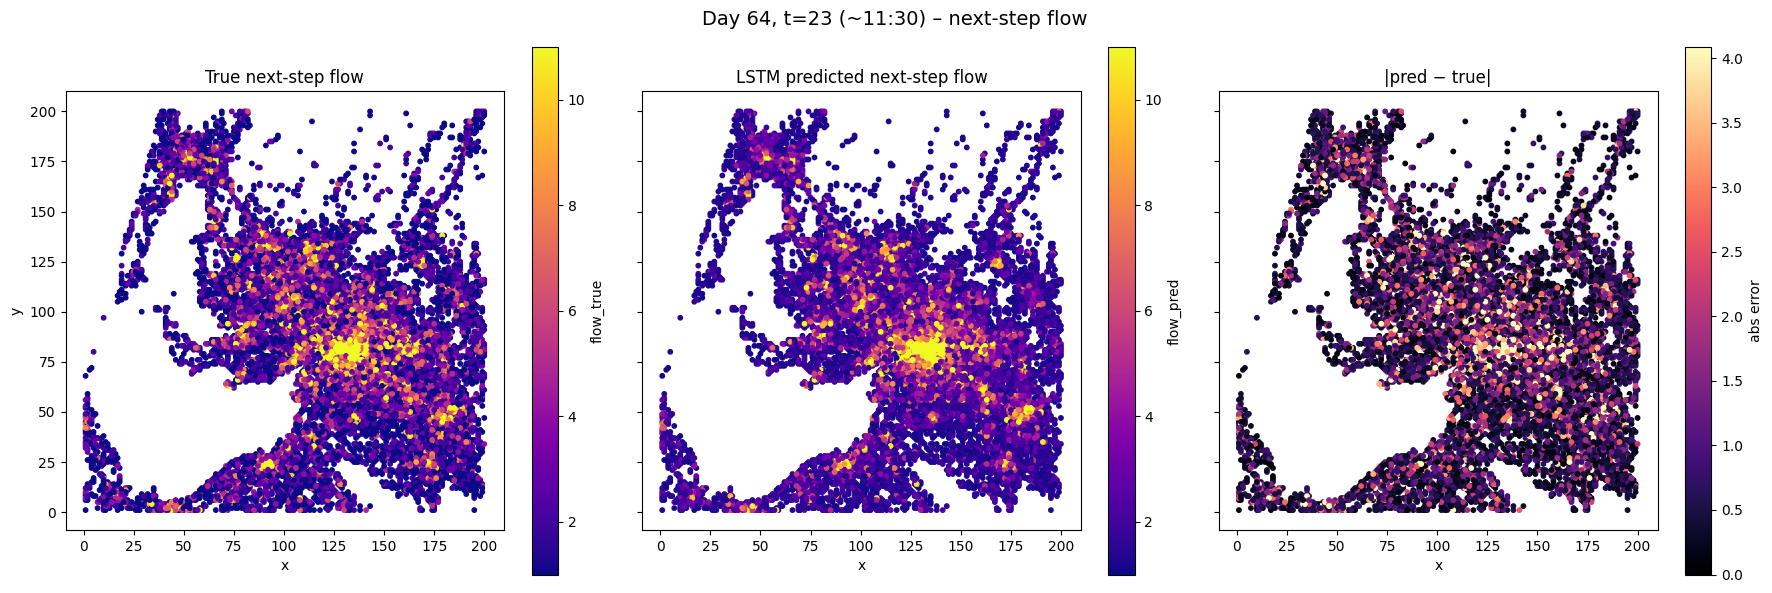

In [ ]:
import matplotlib.pyplot as plt

vmin = np.percentile(snap["flow_true"], 5)
vmax = np.percentile(snap["flow_true"], 95)

err_max = np.percentile(snap["err_abs"], 95)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

ax = axes[0]
sc0 = ax.scatter(
    snap["x"], snap["y"],
    c=snap["flow_true"],
    s=10,
    cmap="plasma",
    vmin=vmin,
    vmax=vmax
)
ax.set_title("True next-step flow")
ax.set_aspect("equal")
ax.grid(False)
plt.colorbar(sc0, ax=ax, label="flow_true")

ax = axes[1]
sc1 = ax.scatter(
    snap["x"], snap["y"],
    c=snap["flow_pred"],
    s=10,
    cmap="plasma",
    vmin=vmin,
    vmax=vmax
)
ax.set_title("LSTM predicted next-step flow")
ax.set_aspect("equal")
ax.grid(False)
plt.colorbar(sc1, ax=ax, label="flow_pred")

ax = axes[2]
sc2 = ax.scatter(
    snap["x"], snap["y"],
    c=snap["err_abs"],
    s=10,
    cmap="magma",
    vmin=0,
    vmax=err_max
)
ax.set_title("|pred − true|")
ax.set_aspect("equal")
ax.grid(False)
plt.colorbar(sc2, ax=ax, label="abs error")

for ax in axes:
    ax.set_xlabel("x")
axes[0].set_ylabel("y")

minutes = t_plot * 30
hh = minutes // 60
mm = minutes % 60
plt.suptitle(f"Day {d0}, t={t_plot} (~{hh:02d}:{mm:02d}) – next-step flow", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
d0 = 64

t_list = [8, 12, 16, 20, 24, 28]

snap_list = []

model.eval()

for t_plot in t_list:
    snap_true = con.execute("""
        SELECT
            x,
            y,
            flow_next AS target,
            time_index
        FROM flow_feat_test
        WHERE (time_index / 48)::INT = ?
          AND (time_index % 48) = ?;
    """, [d0, t_plot]).fetchdf()

    X_list, target_list, x_list, y_list = [], [], [], []

    for idx, row in snap_true.iterrows():
        x0 = int(row["x"])
        y0 = int(row["y"])
        T  = int(row["time_index"])
        y_true = float(row["target"])

        seq_df = con.execute(f"""
            SELECT time_index, {", ".join(feature_cols)}
            FROM (
                SELECT time_index, {", ".join(feature_cols)}
                FROM flow_feat_test
                WHERE x = ? AND y = ?
                  AND (time_index / 48)::INT = ?
                  AND time_index <= ?
                ORDER BY time_index DESC
                LIMIT ?
            )
            ORDER BY time_index;
        """, [x0, y0, d0, T, SEQ_LEN]).fetchdf()

        if len(seq_df) < SEQ_LEN:
            continue

        feats = seq_df[feature_cols].to_numpy(dtype="float32")
        feats_norm = (feats - mean) / std

        X_list.append(feats_norm)
        target_list.append(y_true)
        x_list.append(x0)
        y_list.append(y0)

    if len(X_list) == 0:
        print(f"t={t_plot} no enough")
        continue

    X = np.stack(X_list).astype("float32")
    y_true_arr = np.array(target_list, dtype="float32")

    with torch.no_grad():
        xb = torch.from_numpy(X).to(device)
        y_pred_arr = model(xb).cpu().numpy()

    snap = pd.DataFrame({
        "x": x_list,
        "y": y_list,
        "flow_true": y_true_arr,
        "flow_pred": y_pred_arr,
    })
    snap["err_abs"] = np.abs(snap["flow_pred"] - snap["flow_true"])
    snap["t_plot"] = t_plot

    snap_list.append(snap)

print("usable time points", len(snap_list))


t=28 no enough
usable time points 5


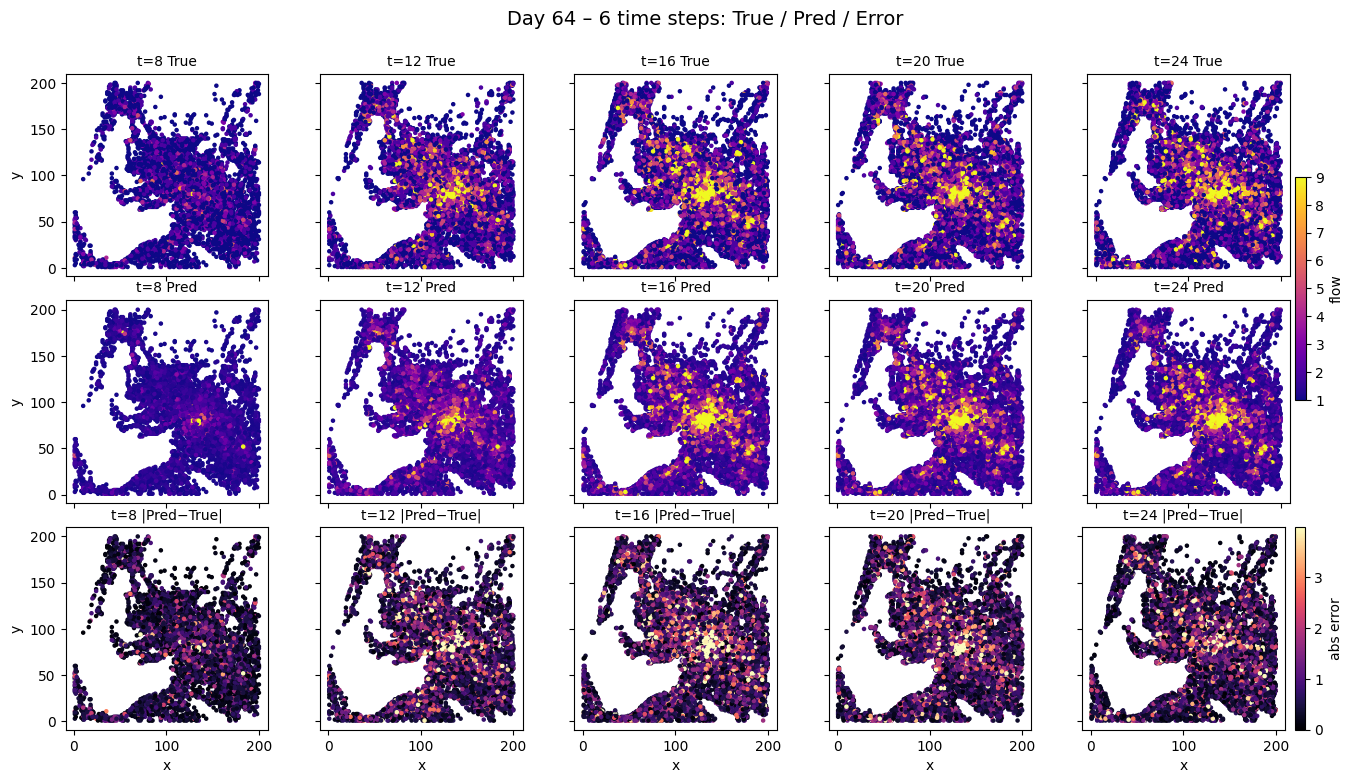

In [ ]:
all_snap = pd.concat(snap_list, ignore_index=True)
vmin = np.percentile(all_snap["flow_true"], 5)
vmax = np.percentile(all_snap["flow_true"], 95)
err_max = np.percentile(all_snap["err_abs"], 95)

n_times = len(snap_list)
snap_list_sorted = sorted(snap_list, key=lambda s: s["t_plot"].iloc[0])

fig, axes = plt.subplots(
    3, n_times,
    figsize=(3.0 * n_times, 8),
    sharex=True, sharey=True
)

sc_true = None
sc_err = None

for j, snap in enumerate(snap_list_sorted):
    t_plot = snap["t_plot"].iloc[0]

    ax = axes[0, j]
    sc_true = ax.scatter(
        snap["x"], snap["y"],
        c=snap["flow_true"],
        s=5,
        cmap="plasma",
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f"t={t_plot} True", fontsize=10)
    ax.set_aspect("equal")
    ax.grid(False)

    ax = axes[1, j]
    ax.scatter(
        snap["x"], snap["y"],
        c=snap["flow_pred"],
        s=5,
        cmap="plasma",
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f"t={t_plot} Pred", fontsize=10)
    ax.set_aspect("equal")
    ax.grid(False)

    ax = axes[2, j]
    sc_err = ax.scatter(
        snap["x"], snap["y"],
        c=snap["err_abs"],
        s=5,
        cmap="magma",
        vmin=0, vmax=err_max
    )
    ax.set_title(f"t={t_plot} |Pred−True|", fontsize=10)
    ax.set_aspect("equal")
    ax.grid(False)

for j in range(n_times):
    axes[2, j].set_xlabel("x")
for i in range(3):
    axes[i, 0].set_ylabel("y")

plt.subplots_adjust(
    left=0.06, right=0.9,
    top=0.9, bottom=0.08,
    wspace=0.05, hspace=0.12
)

cbar1 = fig.colorbar(
    sc_true,
    ax=axes[0:2, -1],
    fraction=0.046,
    pad=0.02
)
cbar1.set_label("flow")

cbar2 = fig.colorbar(
    sc_err,
    ax=axes[2, -1],
    fraction=0.046,
    pad=0.04
)
cbar2.set_label("abs error")

plt.suptitle(f"Day {d0} – 6 time steps: True / Pred / Error", fontsize=14)
plt.show()